# DCGAN
### This notebook contains an implementation of the model described [here](https://arxiv.org/abs/1511.06434)

## Dataset

### Loading

In [1]:
from scripts.load_data import load_dataset
dataset = load_dataset("scapes", normalize=True, batch=True)

### Training image preview

3


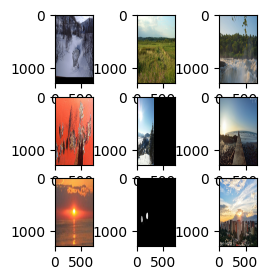

In [ ]:
from scripts.visualization import display_images
import tensorflow as tf

# Take doesn't alter the dataset itself, so this won't affect the training
for batch in dataset.take(1):
    display_images(batch.numpy(), max_images=9)


## Imports for building models

In [73]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Reshape, UpSampling2D, Conv2D, Conv2DTranspose, Flatten, Dropout, LeakyReLU, BatchNormalization, ZeroPadding2D

## Model Utils

In [74]:
def get_dcgan_specs(width, height):
    '''
    num_hidden_conv_layers:
        Equal to number of times we can evenly divide the width and height by 2.
        This is done this way since we use upsampling in each hidden layer which
        doubles the width and height.

    initial_num_filters 
        Derived from num_hidden_conv_layers. The goal is to have 128 filters in
        the last hidden layer. Since we halve the number of filters each time we
        upsample (as we do in each hidden conv layer) we can calculate the
        initial number of filters by taking 128 and doubling it for each hidden
        conv layer.
    '''

    num_hidden_conv_layers = 0
    while width > 4 and height > 4:
        width = width / 2
        height = height / 2
        if width.is_integer() and height.is_integer():
            num_hidden_conv_layers += 1
        else:
            break
    
    initial_width = width * 2
    initial_height = height * 2

    initial_num_filters = 128 * (2**num_hidden_conv_layers)
    
    specs = {
        'num_hidden_conv_layers': int(num_hidden_conv_layers),
        'initial_width': int(initial_width),
        'initial_height': int(initial_height),
        'initial_num_filters': int(initial_num_filters)
    }


    return specs

## Building toy model

In [ ]:
def build_generator(output_width, output_height, num_color_channels):
    print(num_color_channels)
    generator = Sequential([
      Dense(7*7*256, activation='relu',input_dim=len_seed), # Initial flat hidden layer
      Reshape((7, 7, 256)), # Reshape to 7x7x256 i.e. a 7x7 image with 256 filters

      UpSampling2D(), # Doubles the resolution of the representation (from 7x7x256 to 14x14x256)
      Conv2D(256, kernel_size=3, padding='same', activation='relu'),

      UpSampling2D(), # 28x28x128
      Conv2D(128, kernel_size=3, padding='same', activation='relu'),

      Conv2D(num_color_channels, kernel_size=3, padding='same') # Combine/Process 128 filters into 1 color channel
    ])

    return generator

def build_discriminator():
  image_shape = (28, 28, 1)

  discriminator = Sequential([
    Conv2D(32, kernel_size=3, input_shape=image_shape, padding='same', activation='relu'),
    Conv2D(64, kernel_size=3, padding='same', activation='relu'),
    Conv2D(128, kernel_size=3, padding='same', activation='relu'),
    Conv2D(256, kernel_size=3, padding='same', activation='relu'),
    Conv2D(512, kernel_size=3, padding='same', activation='relu'),
    Flatten(),
    Dense(1, activation='sigmoid')
  ])

  return discriminator

## Building DCGAN model

In [99]:
# weight initializer for all layers as suggested in the paper 
weight_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02, seed=None)

def build_generator(output_width, output_height, num_color_channels):
  specs = get_dcgan_specs(output_width, output_height)

  input_layers = [
    Input(shape=(len_seed,)),
    Dense(
      specs['initial_width'] * specs['initial_height'] * specs['initial_num_filters'], 
      activation='relu', 
      kernel_initializer=weight_initializer
    ),
    Reshape((specs['initial_width'], specs['initial_height'], specs['initial_num_filters']))
  ]

  hidden_convolutional_layers = []
  for i in range(specs['num_hidden_conv_layers']):
    layers = [
      Conv2DTranspose(
        # Input layer has initial_num_filters, each hidden layer has half the
        # number of filters of the previous hidden layer
        specs['initial_num_filters'] // (2**(i + 1)), 
        kernel_size=3, 
        strides=2,
        padding='same', 
        activation='relu', 
        kernel_initializer=weight_initializer
      ),
      BatchNormalization(momentum=0.8)
    ]
    hidden_convolutional_layers.extend(layers)

  output_layers = [
    Conv2D(
      num_color_channels, 
      kernel_size=3, 
      padding='same', 
      activation='tanh', 
      kernel_initializer=weight_initializer
    )
  ]


  generator = Sequential(input_layers + hidden_convolutional_layers + output_layers)
  
  return generator
  
def build_discriminator(input_width, input_height, num_color_channels):
  specs = get_dcgan_specs(input_width, input_height)
  initial_num_filters = 64

  input_layers = [
    Input(shape=(input_width, input_height, num_color_channels)),
    Conv2D(
      initial_num_filters, 
      kernel_size=3, 
      strides=2, 
      padding='same'
    ),
    LeakyReLU(0.2),
  ]

  hidden_layers = []
  for i in range(specs['num_hidden_conv_layers'] - 1):
    layers = [
      Conv2D(
        initial_num_filters * (2**(i + 1)),
        kernel_size=3, 
        strides=2, 
        padding='same'
      ),
      LeakyReLU(0.2)
    ]
    hidden_layers.extend(layers)

  output_layers = [
    Flatten(),
    Dense(1, activation='sigmoid')
  ]

  discriminator = Sequential(input_layers + hidden_layers + output_layers)

  return discriminator



## Initialize GAN

In [100]:
generator = build_generator(28, 28, 1)
discriminator = build_discriminator(28, 28, 1)

## Test Generator output

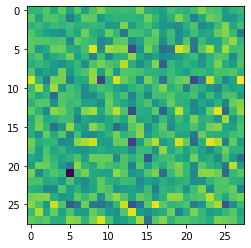

In [101]:
input_noise = tf.random.normal([1, len_seed])
generated_image = generator(input_noise, training=False)
generated_image = ((generated_image + 1) * 127.5) 
# generated_image
plt.imshow(tf.reshape(generated_image, (28, 28)))

## Test Discriminator output

In [102]:
decision = discriminator(generated_image)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.8666275e-09]], dtype=float32)>

## Model summaries

### Generator summary

In [95]:
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 25088)             2533888   
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 512)         0         
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 14, 14, 256)      1179904   
 ranspose)                                                       
                                                                 
 batch_normalization_2 (Batc  (None, 14, 14, 256)      1024      
 hNormalization)                                                 
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 28, 28, 128)      295040    
 ranspose)                                                       
                                                      

### Discriminator summary

In [80]:
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 6272)              0         
                                                                 
 dense_3 (Dense)             (None, 1)                 6273      
                                                                 
Total params: 80,769
Trainable params: 80,769
Non-trai

## Loss Functions

### Imports

In [81]:
from typing import BinaryIO
from tensorflow.keras.losses import BinaryCrossentropy

### Generator loss

In [82]:
binary_cross_entropy = BinaryCrossentropy(from_logits=True)

In [83]:
def generator_loss(y_pred_fake):
  return binary_cross_entropy(tf.ones_like(y_pred_fake), y_pred_fake)

### Discriminator loss

In [84]:
def discriminator_loss(y_pred_real, y_pred_fake):
  real_loss = binary_cross_entropy(tf.ones_like(y_pred_real), y_pred_real)
  fake_loss = binary_cross_entropy(tf.zeros_like(y_pred_fake), y_pred_fake)
  return real_loss + fake_loss

## Optimizers

### Imports

In [85]:
from tensorflow.keras.optimizers import Adam

### Generator optimizer

In [86]:
generator_optimizer = Adam(0.0002, 0.5) # Recommended values from DCGAN paper

### Discriminator optimizer

In [87]:
discriminator_optimizer = Adam(0.0002, 0.5)

## Set up checkpoint

In [88]:
import os

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Training function

### Imports

In [89]:
import time
from IPython import display

### Training function definitions

In [90]:
# @tf.function
def train_step(real_image_batch, batch_size):
  input_noise_seeds = tf.random.normal([batch_size, len_seed])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_image_batch = generator(input_noise_seeds, training=True)

    y_pred_real = discriminator(real_image_batch, training=True)
    y_pred_fake = discriminator(generated_image_batch, training=True)

    gen_loss = generator_loss(y_pred_fake)
    disc_loss = discriminator_loss(y_pred_real, y_pred_fake)

    print(f'Generator loss: {gen_loss}, Discriminator loss: {disc_loss}', end='\r')

    generator_gradient = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradient, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradient, discriminator.trainable_variables))

    return gen_loss, disc_loss


In [92]:
def generate_and_save_images(model, epoch, test_seeds):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_seeds, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [91]:
def train(dataset, epochs, batch_size, num_test_seeds):
  if not (len(dataset) / batch_size).is_integer():
    print('Batch size not compatible with dataset size')
    return

  if num_test_seeds < 1:
    print('Number of test seeds invalid (must be > 0)')
    return
  
  test_seeds = tf.random.normal([num_test_seeds, len_seed])

  # Assumes that the dataset has already been preprocessed
  # Expected dataset shape (num_instances, width, height, color_channels)
  num_images = len(dataset)

  for epoch in range(epochs):
    
    start = time.time()
    gen_loss, disc_loss = None, None
    for i in range(len(dataset)//batch_size):
      display.clear_output(wait=True)
      real_image_batch = dataset[i * batch_size : (i + 1) * batch_size]
      print(f'Loss for previous batch #{i}: Generator loss = {gen_loss}, Discriminator loss = {disc_loss}')
      print(f'Epoch # {epoch + 1}/{epochs}')
      print(f'Batch # {i}/{len(dataset)//batch_size}')
      gen_loss, disc_loss = train_step(real_image_batch, batch_size)
      
    generate_and_save_images(generator, epoch + 1, test_seeds)

    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

    print(f'Time for epoch {epoch + 1} is {time.time()-start} sec')
  
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, test_seeds)

## Training the model

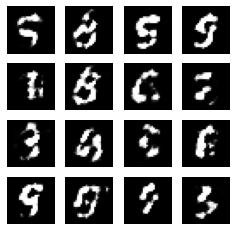

Total training time (in seconds): 52.70965504646301


In [103]:
start = time.time()
train(training_data, epochs=1, batch_size=125, num_test_seeds=16)
end = time.time()
print(f'Total training time (in seconds): {end - start}')

## Rescaling image output from [-1, 1] to [0, 255]

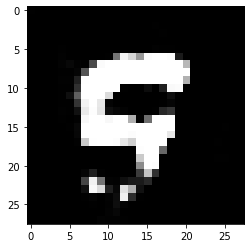

In [110]:
rand_seed = tf.random.normal([1, 100])
image = generator(rand_seed, training=False)[0]
plt.imshow(image[:,:,0], cmap='gray')

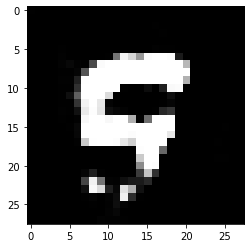

In [111]:
image = (image + 1)/(2) * 255
np.min(image), np.max(image)
# # image = np.expand_dims(image, axis=0)
# # rand_seed
plt.imshow(image[:, :, 0], cmap='gray')

## Saving the model

In [ ]:
generator.save('./models/generator')

In [ ]:
discriminator.save('./models/discriminator')

## Download folder

In [ ]:
!tar cvf toy_model_batch_processing.tgz toy_model_batch_processing/

In [ ]:
!tar cvf generator.tgz ./models/generator